<a href="https://colab.research.google.com/github/EricSiq/solar-farms-mapping/blob/main/Inference_Demo_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fiona

In [ ]:
!pip install rasterio

In [ ]:
# Copyright (c) Microsoft Corporation. All rights reserved
# Licensed under the MIT License.
%matplotlib inline
import sys, os
sys.path.append("../")
from models.unet import UnetModel
import pickle
import torch
import numpy as np
from torch.autograd import Variable
from skimage.transform import resize
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import seaborn as sns
from skimage.draw import polygon
import fiona
import shapely
import rasterio
from shapely import geometry
from rasterio.mask import mask as rio_mask
import numpy as np
import cv2

In [ ]:
RASTERIO_BEST_PRACTICES = dict(
    CURL_CA_BUNDLE='/etc/ssl/certs/ca-certificates.crt',
    GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR',
    AWS_NO_SIGN_REQUEST='YES',
    GDAL_MAX_RAW_BLOCK_CACHE_SIZE='200000000',
    GDAL_SWATH_SIZE='200000000',
    VSI_CURL_CACHE_SIZE='200000000'
)

In [ ]:
mean = [660.5929, 812.9481, 1080.6552, 1398.3968, 1662.5913, 1899.4804, 2061.932, 2100.2792, 2214.9325, 2230.5973, 2443.3014, 1968.1885],
std = [137.4943, 195.3494, 241.2698, 378.7495, 383.0338, 449.3187, 511.3159, 547.6335, 563.8937, 501.023, 624.041, 478.9655]

In [ ]:
sentinel_urls = [
        "https://researchlabwuopendata.blob.core.windows.net/sentinel-2-imagery/karnataka_change/2020/2020_merged.tif"
    ]


In [ ]:
sentinel_urls = [
    "/vsicurl/https://researchlabwuopendata.blob.core.windows.net/sentinel-2-imagery/karnataka_change/2020/2020_merged.tif"
]
#new sentinel_urls

In [ ]:
def scale(x, min_val, max_val, a=0, b=255, output_type=np.uint8):
    y = np.clip((x - min_val) / (max_val - min_val), 0, 1)
    y = (b-a) * y + a
    y = y.astype(output_type)
    return y

def get_mask_and_bounding_geoms(geom, buffer):
    footprint_shape = shapely.geometry.shape(geom).buffer(0.0)
    bounding_shape = footprint_shape.envelope.buffer(buffer).envelope
    mask_geom = shapely.geometry.mapping(bounding_shape - footprint_shape) # full bounding area - initial footprint
    bounding_geom = shapely.geometry.mapping(bounding_shape) # full bounding area
    return mask_geom, bounding_geom

def get_sentinel_stack_from_geom(geom, buffer, urls):
    mask_geom, bounding_geom = get_mask_and_bounding_geoms(geom, buffer)
    images = []
    masks = []
    for url in urls:
        with rasterio.Env(**RASTERIO_BEST_PRACTICES):
            with rasterio.open(url) as f:
                mask_image, _ = rio_mask(f, [mask_geom], crop=True, invert=False, pad=False, all_touched=True)
                mask_image = np.rollaxis(mask_image, 0, 3)
                mask_image = mask_image[:,:,[3,2,1]]

                full_image, _ = rio_mask(f, [bounding_geom], crop=True, invert=False, pad=False, all_touched=True)
                full_image = np.rollaxis(full_image, 0, 3)
                full_image = full_image[:,:,[3,2,1]]
                full_image = scale(full_image, 0, 3000)

                mask = np.zeros((mask_image.shape[0], mask_image.shape[1]), dtype=np.uint8)
                mask[np.sum(mask_image == 0, axis=2) != 3] = 1
        images.append(full_image)
        masks.append(mask)
    return images, masks

def get_full_sentinel_stack_from_geom(geom, buffer, urls):
    mask_geom, bounding_geom = get_mask_and_bounding_geoms(geom, buffer)
    images = []
    for url in urls:
        with rasterio.Env(**RASTERIO_BEST_PRACTICES):
            with rasterio.open(url) as f:
                full_image, _ = rio_mask(f, [bounding_geom], crop=True, invert=False, pad=False, all_touched=True)
                full_image = np.rollaxis(full_image, 0, 3)
        images.append(full_image)
    return images



def get_sentinel_rgb_stack_from_geom(geom, buffer, urls):
    image_stack, masks  = get_sentinel_stack_from_geom(geom, buffer, urls)
    return image_stack


In [ ]:
plt.rcParams.update({'font.size': 15})

def plot_sample_prediction(image, pred):
    '''
    Plots and a slice with all available annotations
    '''
    image = resize(image, (512, 512, 3), anti_aliasing=True)
    pred = resize(pred, (512, 512), anti_aliasing=True)
    flatui = ["#3498db", "#FFD700"]
    #flatui = ["#3498db", "#651FFF"]
    color_map = ListedColormap(sns.color_palette(flatui).as_hex())

    legend_elements = [
                   Line2D([0], [0], marker='o', color='w', label='Solar Farm Prediction', markerfacecolor=color_map(1), markersize=15)]

    fig = plt.figure(figsize=(18, 18))

    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(1, 4, 2)
    plt.imshow(image)
    pred = np.ma.masked_where(pred == 0, pred)
    plt.imshow(pred, alpha=0.5, interpolation='none', cmap=color_map, vmin=0, vmax=1)
    plt.axis("off")
   # plt.title('Prediction Overlay')

    plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1))
    plt.tight_layout()



In [ ]:
def get_all_geoms_from_file(fn):
    geoms = []
    with fiona.open(fn) as f:
        for row in f:
            geom = row["geometry"]
            geoms.append(geom)
    return geoms

In [ ]:
geoms = get_all_geoms_from_file("/content/karnataka_predictions_polygons_validated_2020.geojson")


In [ ]:
gpu_ids = [0]
device = torch.device('cuda:{}'.format(gpu_ids[0]) if torch.cuda.is_available() else 'cpu')
model_dir = "/content/unet_hnm"


class InferenceFramework():
    def __init__(self, model, opts):
        self.opts = opts
        self.model = model(self.opts)
        self.model.to(device)

    def load_model(self, path_2_model):
        checkpoint = torch.load(path_2_model, map_location=torch.device('cpu') if not torch.cuda.is_available() else None, weights_only=False)
        self.model.load_state_dict(checkpoint['model'])
        self.model.eval()

    def predict_single_image(self, x):
        y_pred = self.model.forward(x.unsqueeze(0))
        return np.squeeze(np.argmax((Variable(y_pred).data).cpu().numpy(), axis=1))


def load_options(file_name):
    opt = pickle.load(open(file_name + '.pkl', 'rb'))
    return opt


def get_prediction(x, opts, model_dir):
    if opts.model == "unet":
        model = UnetModel
    else:
        raise NotImplementedError

    inf_framework = InferenceFramework(
        model,
        opts
    )
    inf_framework.model.to(device)
    inf_framework.load_model(os.path.join(model_dir, "checkpoint.pth.tar"))

    y_hat = inf_framework.predict_single_image(torch.from_numpy(x).float().to(device))
    return y_hat

In [ ]:
def get_predictions(images):
    predictions = []
    opts = load_options(model_dir +'/opt')
    for img in images:
        img = cv2.resize(img, (256, 256))
        x = (img-mean) / std
        x = np.moveaxis(x, 2, 0)
        y_hat = np.squeeze(get_prediction(x, opts, model_dir))
        contours = find_contours(y_hat, 0.5)
        solar_mask = np.zeros(y_hat.shape)
        for n, contour in enumerate(contours):
        # Construct the rotatedbox. If its aspect ratio is too small, we ignore it
            ll, ur = np.min(contour, 0), np.max(contour, 0)
            wh = ur - ll
            if wh[0] * wh[1] < 5:
                continue
            else:
                #fill mask for solar farm
                rr, cc = polygon(contour[:, 0], contour[:, 1], solar_mask.shape)
                solar_mask[rr, cc] = 1

        predictions.append(solar_mask)
    return predictions


In [ ]:
i = 5
shape_area = geometry.shape(geoms[i]).area
side_length = np.sqrt(shape_area)
buffer_size = max(side_length * 1.5, 0.001)
images = get_full_sentinel_stack_from_geom(geoms[i], buffer=buffer_size, urls=sentinel_urls)
predictions = get_predictions(images)
rgb_images = get_sentinel_rgb_stack_from_geom(geoms[i], buffer=buffer_size, urls=sentinel_urls)

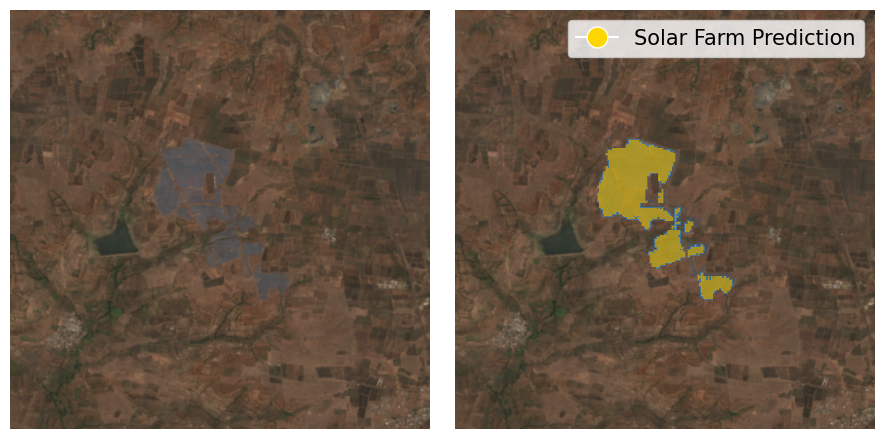

In [ ]:
predicited_sample=plot_sample_prediction(rgb_images[0], predictions[0])
predicited_sample

IoU Score: 0.0000
Intersection Pixels: 0
Union Pixels: 2159


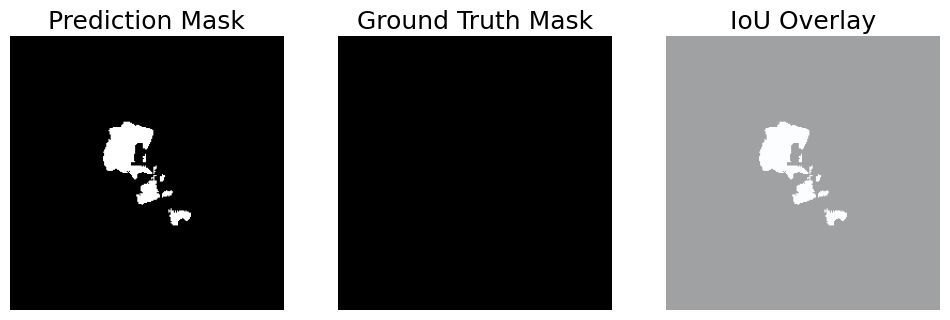

In [ ]:
import fiona
from shapely.geometry import shape
from rasterio.features import rasterize
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage.measure import find_contours
from skimage.draw import polygon
import cv2
import rasterio

# Step 1: Load ground truth geometries
geojson_path = "/content/karnataka_predictions_polygons_validated_2020.geojson"
with fiona.open(geojson_path, "r") as src:
    geoms = [shape(feature["geometry"]) for feature in src]

# Step 2: Rasterize the ground truth geometries
image_shape = (256, 256)  # Replace with actual dimensions of your input image
ground_truth_mask = rasterize(
    [(geom, 1) for geom in geoms],
    out_shape=image_shape,
    fill=0,
    dtype=np.uint8
)

# Step 3: Obtain the predicted mask from your model
# Assuming you have a function get_predictions that returns a list of predicted masks
# and a function get_full_sentinel_stack_from_geom to get the input image
i = 5  # Index of the geometry to process
shape_area = geoms[i].area
side_length = np.sqrt(shape_area)
buffer_size = max(side_length * 1.5, 0.001)
sentinel_urls = [
    "/vsicurl/https://researchlabwuopendata.blob.core.windows.net/sentinel-2-imagery/karnataka_change/2020/2020_merged.tif"
]
images = get_full_sentinel_stack_from_geom(geoms[i], buffer=buffer_size, urls=sentinel_urls)
predictions = get_predictions(images)
predicted_mask = predictions[0]  # Assuming the first prediction corresponds to the input image

# Step 4: Compute IoU
import numpy as np

def compute_iou(pred_mask, gt_mask):
    """
    Compute Intersection over Union (IoU) between predicted and ground truth masks.
    """
    pred_mask = (pred_mask > 0).astype(np.uint8)
    gt_mask = (gt_mask > 0).astype(np.uint8)

    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()

    iou = intersection / union if union > 0 else 0.0
    return iou, intersection, union


iou_score, intersection, union = compute_iou(predicted_mask, ground_truth_mask)
print(f"IoU Score: {iou_score:.4f}")
print(f"Intersection Pixels: {intersection}")
print(f"Union Pixels: {union}")

# Visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(predicted_mask, cmap="gray")
plt.title("Prediction Mask")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(ground_truth_mask, cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap="gray", alpha=0.6)
plt.imshow(ground_truth_mask, cmap="Blues", alpha=0.4)
plt.title("IoU Overlay")
plt.axis("off")
plt.show()


IoU Score: 0.0000
Intersection Pixels: 0
Union Pixels: 2159


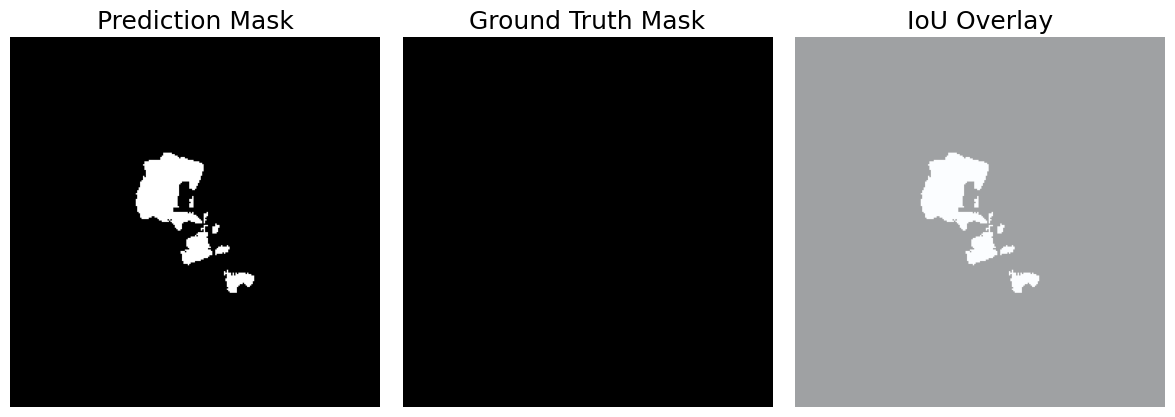

In [ ]:
import fiona
from shapely.geometry import shape
from rasterio.features import rasterize
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt
import cv2
import rasterio

# Step 1: Load ground truth geometries
geojson_path = "/content/karnataka_predictions_polygons_validated_2020.geojson"
with fiona.open(geojson_path, "r") as src:
    geoms = [shape(feature["geometry"]) for feature in src]

# Step 2: Select the geometry of interest
i = 5  # Index of the geometry to process
selected_geom = geoms[i]

# Step 3: Calculate buffer size based on geometry area
shape_area = selected_geom.area
side_length = np.sqrt(shape_area)
buffer_size = max(side_length * 1.5, 0.001)

# Step 4: Define Sentinel image URLs
sentinel_urls = [
    "/vsicurl/https://researchlabwuopendata.blob.core.windows.net/sentinel-2-imagery/karnataka_change/2020/2020_merged.tif"
]

# Step 5: Obtain the input image using the provided function
images = get_full_sentinel_stack_from_geom(selected_geom, buffer=buffer_size, urls=sentinel_urls)
input_image = images[0]  # Assuming the first image corresponds to the selected geometry

# Step 6: Generate the predicted mask using your model
predictions = get_predictions([input_image])
predicted_mask = predictions[0]  # Assuming the first prediction corresponds to the input image

# Step 7: Rasterize the ground truth geometry to create a mask
# Determine the shape of the predicted mask
mask_shape = predicted_mask.shape

# Create a ground truth mask by rasterizing the selected geometry
ground_truth_mask = rasterize(
    [(selected_geom, 1)],
    out_shape=mask_shape,
    fill=0,
    dtype=np.uint8
)

# Step 8: Compute Intersection over Union (IoU)
def compute_iou(pred_mask, gt_mask):
    """
    Compute Intersection over Union (IoU) between predicted and ground truth masks.
    """
    pred_mask = (pred_mask > 0).astype(np.uint8)
    gt_mask = (gt_mask > 0).astype(np.uint8)

    intersection = np.logical_and(pred_mask, gt_mask).sum()
    union = np.logical_or(pred_mask, gt_mask).sum()

    iou = intersection / union if union > 0 else 0.0
    return iou, intersection, union

iou_score, intersection, union = compute_iou(predicted_mask, ground_truth_mask)
print(f"IoU Score: {iou_score:.4f}")
print(f"Intersection Pixels: {intersection}")
print(f"Union Pixels: {union}")

# Step 9: Visualization
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(predicted_mask, cmap="gray")
plt.title("Prediction Mask")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(ground_truth_mask, cmap="gray")
plt.title("Ground Truth Mask")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap="gray", alpha=0.6)
plt.imshow(ground_truth_mask, cmap="Blues", alpha=0.4)
plt.title("IoU Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()


Dice Coefficient: 0.0000


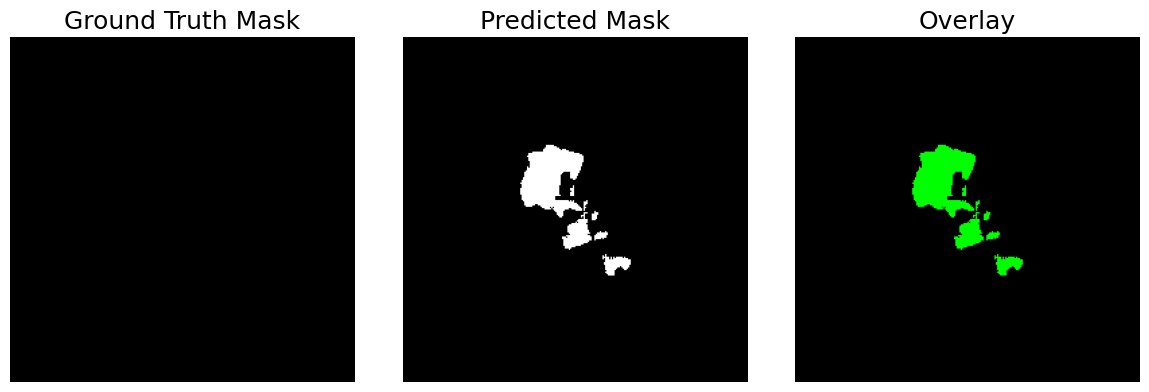

In [ ]:
import fiona
from shapely.geometry import shape
from rasterio.features import rasterize
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load ground truth geometries
geojson_path = "/content/karnataka_predictions_polygons_validated_2020.geojson"
with fiona.open(geojson_path, "r") as src:
    geoms = [shape(feature["geometry"]) for feature in src]

# Step 2: Rasterize the ground truth geometries
image_shape = (256, 256)  # Replace with actual dimensions of your input image
ground_truth_mask = rasterize(
    [(geom, 1) for geom in geoms],
    out_shape=image_shape,
    fill=0,
    dtype=np.uint8
)

# Step 3: Obtain the predicted mask from your model
# Assuming you have a function get_predictions that returns a list of predicted masks
# and a function get_full_sentinel_stack_from_geom to get the input image
i = 5  # Index of the geometry to process
shape_area = geoms[i].area
side_length = np.sqrt(shape_area)
buffer_size = max(side_length * 1.5, 0.001)
sentinel_urls = [
    "/vsicurl/https://researchlabwuopendata.blob.core.windows.net/sentinel-2-imagery/karnataka_change/2020/2020_merged.tif"
]
images = get_full_sentinel_stack_from_geom(geoms[i], buffer=buffer_size, urls=sentinel_urls)
predictions = get_predictions(images)
predicted_mask = predictions[0]  # Assuming the first prediction corresponds to the input image

# Step 4: Compute Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Compute the Dice Coefficient between two binary masks.

    Args:
        y_true (np.ndarray): Ground truth binary mask.
        y_pred (np.ndarray): Predicted binary mask.
        smooth (float): Smoothing factor to avoid division by zero.

    Returns:
        float: Dice Coefficient score.
    """
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    intersection = np.sum(y_true_flat * y_pred_flat)
    return (2. * intersection + smooth) / (np.sum(y_true_flat) + np.sum(y_pred_flat) + smooth)

# Ensure masks are binary
predicted_mask_bin = (predicted_mask > 0).astype(np.uint8)
ground_truth_mask_bin = (ground_truth_mask > 0).astype(np.uint8)

# Compute Dice Coefficient
dice_score = dice_coefficient(ground_truth_mask_bin, predicted_mask_bin)
print(f"Dice Coefficient: {dice_score:.4f}")

# Visualization
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(ground_truth_mask_bin, cmap='gray')
plt.title('Ground Truth Mask')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(predicted_mask_bin, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
# Overlay the masks: ground truth in red, prediction in green
overlay = np.zeros((ground_truth_mask_bin.shape[0], ground_truth_mask_bin.shape[1], 3), dtype=np.uint8)
overlay[ground_truth_mask_bin == 1] = [255, 0, 0]  # Red for ground truth
overlay[predicted_mask_bin == 1] = [0, 255, 0]     # Green for prediction
overlay[(ground_truth_mask_bin == 1) & (predicted_mask_bin == 1)] = [255, 255, 0]  # Yellow for overlap

plt.imshow(overlay)
plt.title('Overlay')
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import fiona
import rasterio
from shapely.geometry import shape, mapping
from rasterio.features import rasterize
import numpy as np

# Load vector geometries
vector_path = "/content/karnataka_predictions_polygons_validated_2020.geojson"
with fiona.open(vector_path, "r") as src:
    vector_crs = src.crs
    geoms = [shape(feature["geometry"]) for feature in src]

# Load raster to get its CRS and transform
raster_path = "/vsicurl/https://researchlabwuopendata.blob.core.windows.net/sentinel-2-imagery/karnataka_change/2020/2020_merged.tif"
with rasterio.open(raster_path) as src:
    raster_crs = src.crs
    transform = src.transform
    out_shape = (src.height, src.width)

# Reproject geometries if CRS doesn't match
if vector_crs != raster_crs:
    import pyproj
    from shapely.ops import transform as shp_transform

    project = pyproj.Transformer.from_crs(pyproj.CRS(vector_crs), pyproj.CRS(raster_crs), always_xy=True).transform
    geoms = [shp_transform(project, geom) for geom in geoms]


In [ ]:
# Rasterize geometries
ground_truth_mask = rasterize(
    [(geom, 1) for geom in geoms if not geom.is_empty],
    out_shape=out_shape,
    transform=transform,
    fill=0,
    dtype=np.uint8,
    all_touched=True  # Set to True to include all pixels touched by geometries
)


In [ ]:
import numpy as np

if np.any(ground_truth_mask):
    print("Rasterization successful: Ground truth mask contains data.")
else:
    print("Warning: Ground truth mask is empty after rasterization.")


Rasterization successful: Ground truth mask contains data.
